**Chapter 7, in-chapter problems**

Assisted by [this video](https://youtu.be/6kQYewSWJDg?t=220), another explanation of WAIC.

In [4]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.interpolate import griddata

In [5]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [6]:
def standardize(vec):
    return (vec - np.mean(vec)) / np.std(vec)

<IPython.core.display.Javascript object>

# Understanding log-score and LPPD

It's unclear to me how this can be used to say whether a model is better or not. One way to think of it is that this R^2 for the training set. The book uses model m_7.1 as the example.

In [7]:
# code modified from the repo

df_brains = pd.DataFrame(
    {
        "species": [
            "afarensis",
            "africanus",
            "habilis",
            "boisei",
            "rudolfensis",
            "ergaster",
            "sapiens",
        ],
        "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
        "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5],  # mass in kg
    }
)

df_brains

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


<IPython.core.display.Javascript object>

In [9]:
# Standardized
df_brains["mass_std"] = standardize(df_brains["mass"])  

# Standardize variables (min-max scale)
df_brains["brain_std"] = (
    df_brains["brain"] / df_brains["brain"].max()
)  # min-max scaling (min at 0)


<IPython.core.display.Javascript object>

In [10]:
df_brains

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.841920,0.324444
1,africanus,452,35.5,-0.990494,0.334815
2,habilis,612,34.5,-1.089544,0.453333
3,boisei,521,41.5,-0.396198,0.385926
4,rudolfensis,752,55.5,0.990494,0.557037
5,ergaster,871,61.0,1.535266,0.645185
6,sapiens,1350,53.5,0.792396,1.000000


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'standardized values')

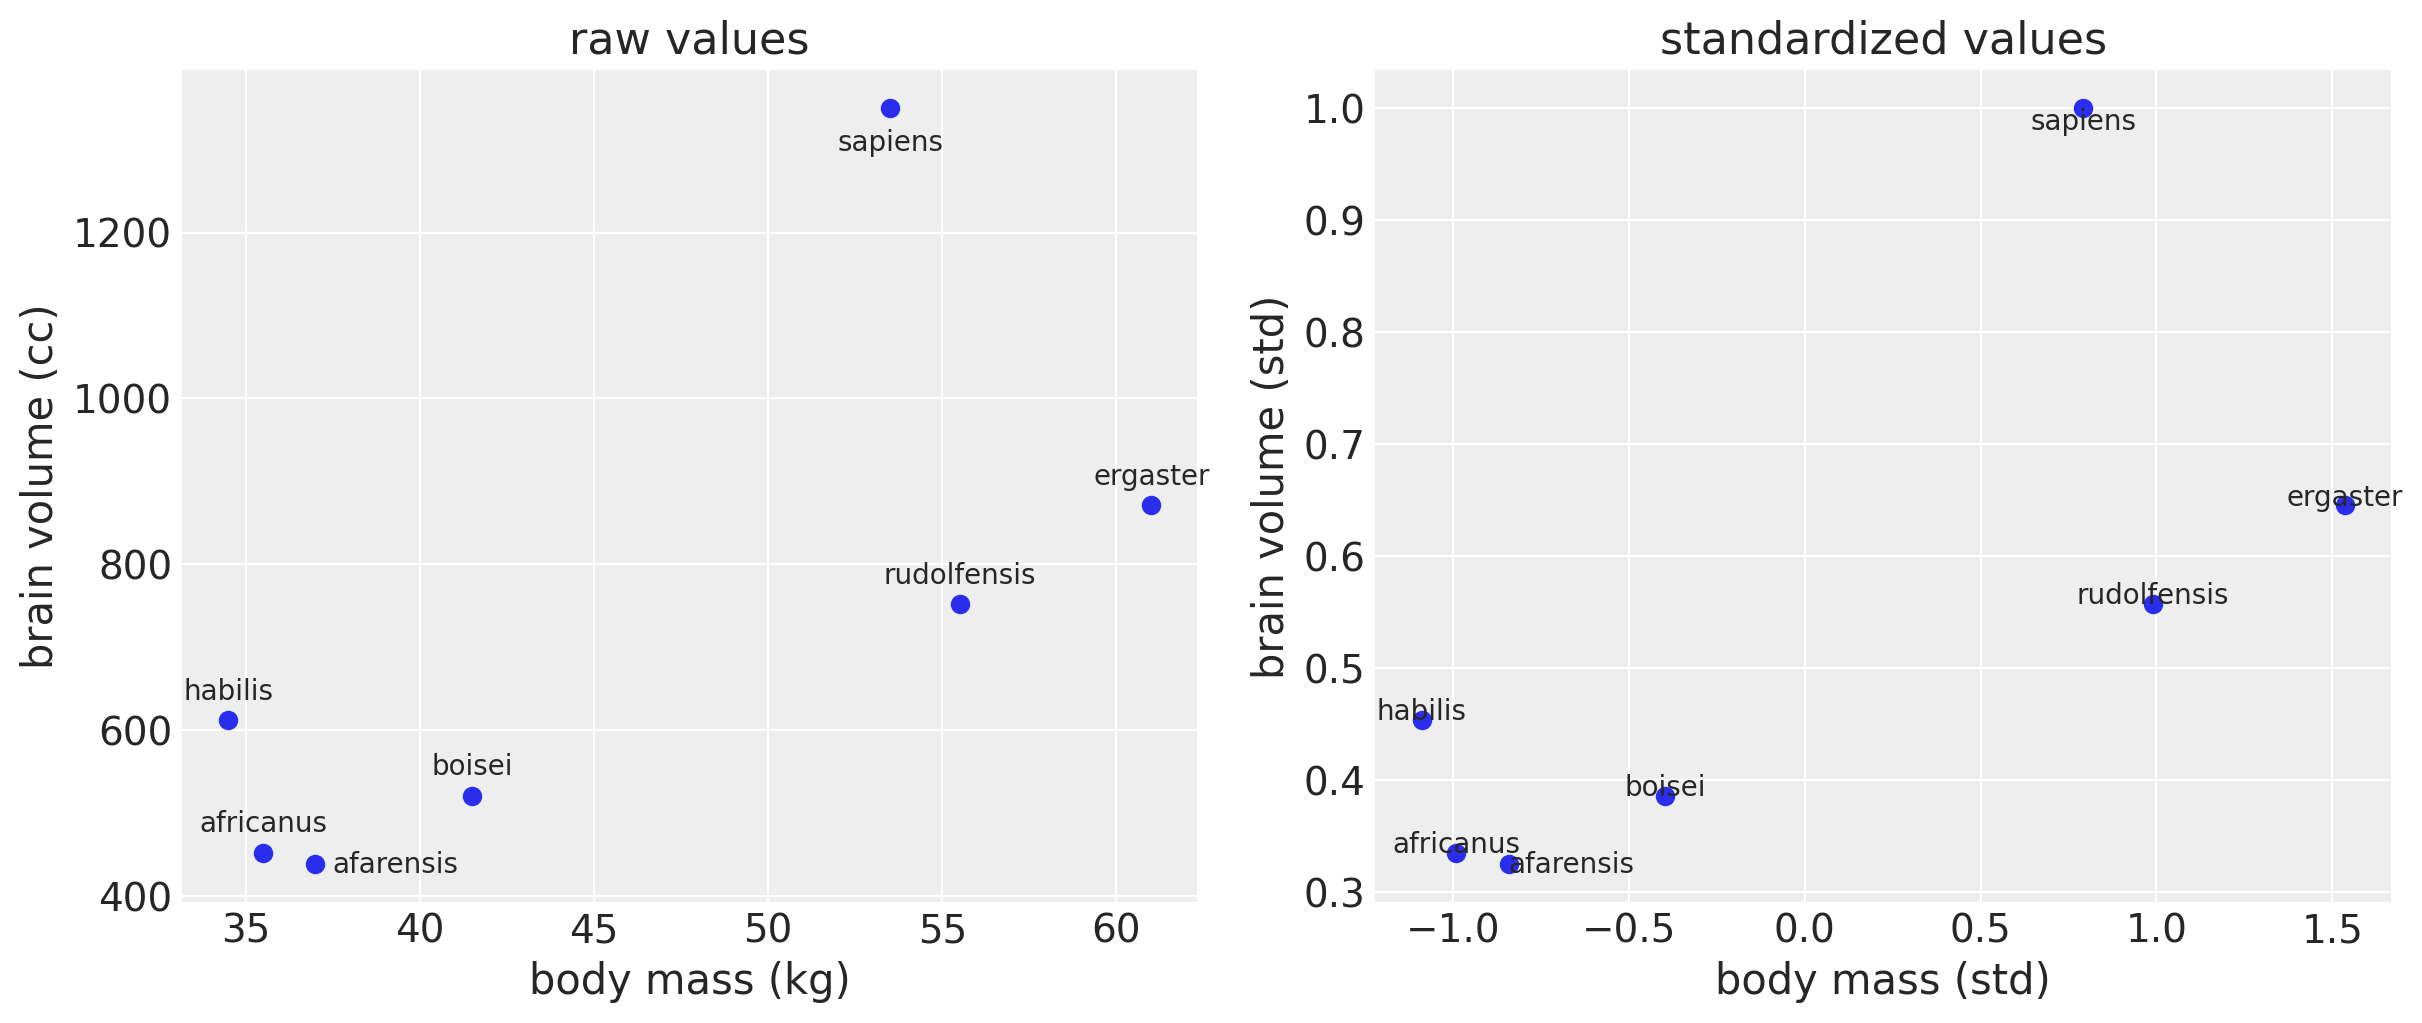

<IPython.core.display.Javascript object>

In [126]:
# Figure 7.2, modified from repo

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(df_brains["mass"], df_brains["brain"])
# point labels
for i, r in df_brains.iterrows():
    if r["species"] == "afarensis":
        ax1.text(r["mass"] + 0.5, r["brain"], r["species"], ha="left", va="center")
    elif r["species"] == "sapiens":
        ax1.text(r["mass"], r["brain"] - 25, r["species"], ha="center", va="top")
    else:
        ax1.text(r["mass"], r["brain"] + 25, r["species"], ha="center")

ax1.set_xlabel("body mass (kg)")
ax1.set_ylabel("brain volume (cc)")
ax1.set_title("raw values")

ax2.scatter(df_brains["mass_std"], df_brains["brain_std"])
# point labels
for i, r in df_brains.iterrows():
    if r["species"] == "afarensis":
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="left", va="center")
    elif r["species"] == "sapiens":
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="center", va="top")
    else:
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="center")

ax2.set_xlabel("body mass (std)")
ax2.set_ylabel("brain volume (std)")
ax2.set_title("standardized values")

## OLS way

The repo uses statsmodels OLS. Ultimately, I'd like to learn with PyMC, but let's start with OLS so that we have something to compare to.

In [11]:
m_7_1 = smf.ols("brain_std ~ mass_std", data=df_brains).fit()
m_7_1.summary()

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              brain_std   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     4.807
Date:                Mon, 17 May 2021   Prob (F-statistic):             0.0798
Time:                        08:12:46   Log-Likelihood:                 2.9925
No. Observations:                   7   AIC:                            -1.985
Df Residuals:                       5   BIC:                            -2.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5287      0.071      7.492      0.001       0.347       0.710
mass_std       0.1547      0.071      2.192      0.080      -0.027       0.336
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.561
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.372
Skew:                           1.399   Prob(JB):                        0.305
Kurtosis:                       3.548   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [12]:
def R2_is_bad_ols(model):
    return 1 - model.resid.var() / df_brains['brain_std'].var()


<IPython.core.display.Javascript object>

In [13]:
R2_is_bad_ols(m_7_1)

0.490158047949084

<IPython.core.display.Javascript object>

In [14]:
m_7_1.resid

0   -0.073970
1   -0.040612
2    0.093232
3   -0.081451
4   -0.124891
5   -0.121031
6    0.348722
dtype: float64

<IPython.core.display.Javascript object>

Shows OLS residual is returning the difference to the mean line. Let's get this from the PyMC posterior.

## PyMC way

Create the model. Here are the variables.

$b_i$ ~ $\text{Normal}(\mu_i, \sigma)$
<br>
$\mu_i$ = $\alpha + \beta m_i$
<br>
$\alpha$ ~ $\text{Normal}(0.5, 1)$
<br>
$\beta$ ~ $\text{Normal}(0, 10)$
<br>
$\sigma$ ~ $\text{Log-Normal}(0, 1)$

In [15]:
with pm.Model() as m7_1:
    a = pm.Normal("a", mu=0.5, sd=1)
    b = pm.Normal("b", mu=0, sd=10)
    log_sigma = pm.Normal("log_sigma", mu=0, sd=1)
    mu = a + b * df_brains["mass_std"]
    brain_std = pm.Normal(
        "brain_std", mu=mu, sd=np.exp(log_sigma), observed=df_brains["brain_std"]
    )

    sample = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

In [16]:
az.summary(sample, kind="stats")

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.526,0.121,0.372,0.708
b,0.158,0.114,0.002,0.329
log_sigma,-1.385,0.397,-2.004,-0.789


<IPython.core.display.Javascript object>

In [17]:
pm.find_MAP(model=m7_1)

{'a': array(0.52854298),
 'b': array(0.15471432),
 'log_sigma': array(-1.70670694)}

<IPython.core.display.Javascript object>

In [18]:
sample.posterior

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    a          (chain, draw) float64 0.4999 0.4932 0.4528 ... 0.5676 0.4917
    b          (chain, draw) float64 0.1145 0.08545 0.03828 ... 0.1979 0.09667
    log_sigma  (chain, draw) float64 -1.807 -1.342 -1.549 ... -1.767 -1.584
Attributes:
    created_at:                 2021-05-17T15:13:03.070451
    arviz_version:              0.11.1
    inference_library:          pymc3
    inference_library_version:  3.11.0
    sampling_time:              11.652981996536255
    tuning_steps:               1000

<IPython.core.display.Javascript object>

Get the mean value at each body mass data point. Since we standardized the values, we use the transformed values first. While we are only using the mean, let's go ahead and use the full posterior values as a re-iteration of a prior lesson. I'll put things in a dataframe since it's more intuitive for me to work with it.

In [45]:
df_sample = sample.to_dataframe()
df_sample.head()

,chain,draw,"(posterior, a)","(posterior, b)","(posterior, log_sigma)","(log_likelihood, brain_std[0], 0)","(log_likelihood, brain_std[1], 1)","(log_likelihood, brain_std[2], 2)","(log_likelihood, brain_std[3], 3)","(log_likelihood, brain_std[4], 4)",...,"(sample_stats, max_energy_error)","(sample_stats, perf_counter_diff)","(sample_stats, perf_counter_start)","(sample_stats, depth)","(sample_stats, mean_tree_accept)","(sample_stats, diverging)","(sample_stats, lp)","(sample_stats, energy)","(sample_stats, process_time_diff)","(sample_stats, energy_error)"
0,0,0,0.499901,0.114539,-1.807259,0.772375,0.838817,0.774701,0.800959,0.829440,...,0.348327,0.000383,9.272113,2,0.886504,False,-4.027976,5.387845,0.000384,-0.275422
1,0,1,0.493239,0.085452,-1.341995,0.354379,0.383196,0.402336,0.383549,0.419876,...,-0.592547,0.000365,9.272593,2,0.916555,False,-4.585001,5.949211,0.000365,0.087133
2,0,2,0.452766,0.038279,-1.548945,0.527734,0.559059,0.610213,0.600432,0.581238,...,0.169593,0.000376,9.273049,2,0.923871,False,-5.278549,5.945732,0.000377,0.102604
3,0,3,0.642973,0.278632,-1.571996,0.571333,0.641051,0.502480,0.403613,-0.866137,...,0.564181,0.000703,9.273515,3,0.778417,False,-6.062883,7.183075,0.000703,0.564181
4,0,4,0.410273,0.140215,-0.794062,-0.127417,-0.134721,-0.218728,-0.127260,-0.125029,...,0.623380,0.000705,9.274313,3,0.838344,False,-6.923262,8.669764,0.000706,0.288928


<IPython.core.display.Javascript object>

(It looks like there's a lot of useful information here but I will ignore everything except the `posterior` columns right now.)

In [42]:
# This is generating a matrix where the predicted mu values will be kept
# Each weight value will be its own row
mu_pred = np.zeros((len(df_brains["mass_std"]), len(df_sample)))

# Fill out the matrix in this loop, note the tuple syntax to reference the posterior values
for i, m in enumerate(df_brains["mass_std"]):
    mu_pred[i] = df_sample[("posterior", "a")] + df_sample[("posterior", "b")] * m

<IPython.core.display.Javascript object>

In [44]:
mu_pred.shape

(7, 4000)

<IPython.core.display.Javascript object>

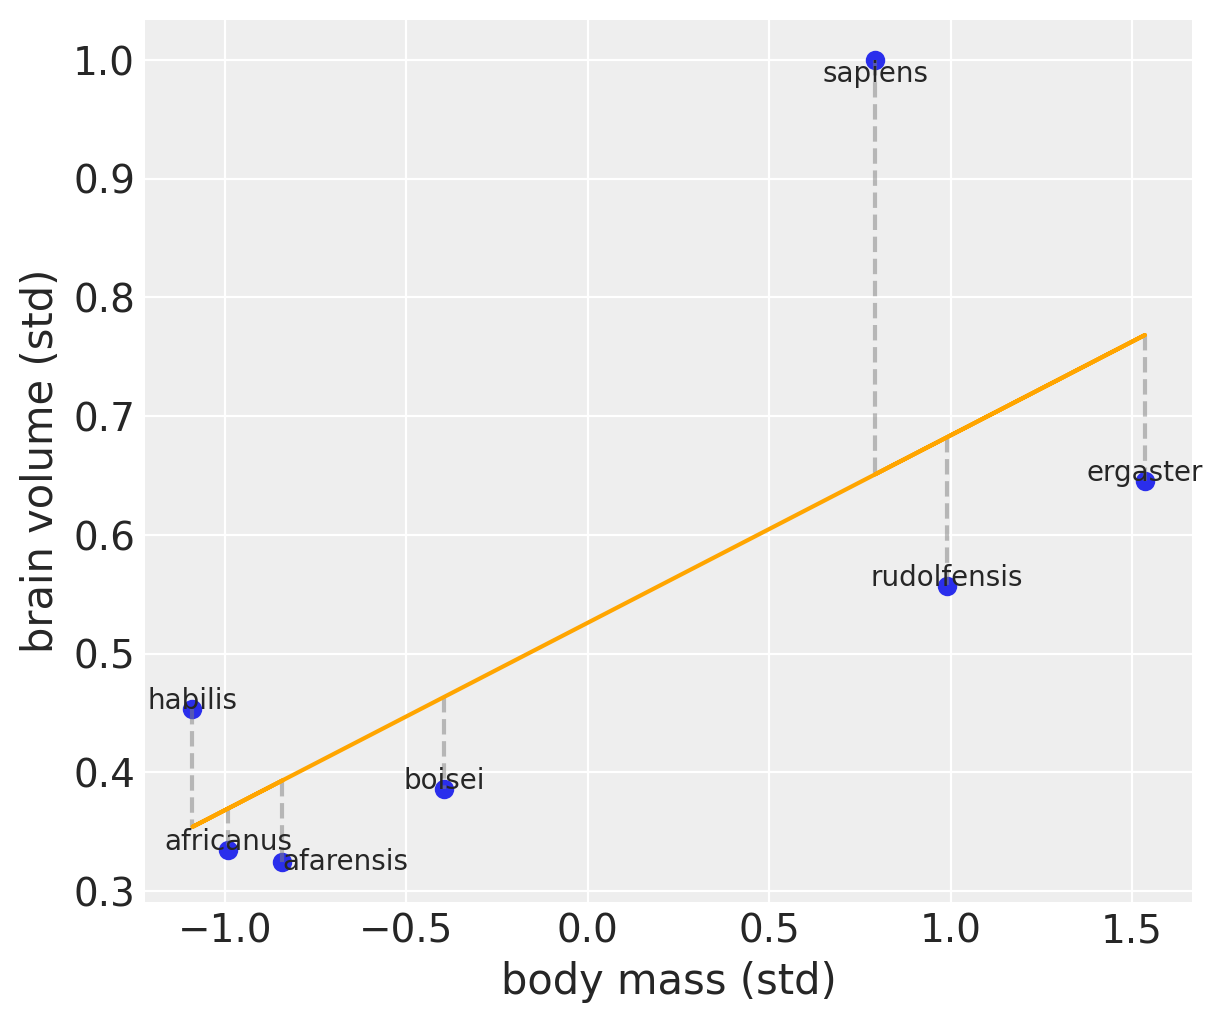

<IPython.core.display.Javascript object>

In [89]:
f, (ax2) = plt.subplots(1, 1, figsize=(6, 5))

ax2.scatter(df_brains["mass_std"], df_brains["brain_std"])
# point labels
for i, r in df_brains.iterrows():
    if r["species"] == "afarensis":
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="left", va="center")
    elif r["species"] == "sapiens":
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="center", va="top")
    else:
        ax2.text(r["mass_std"], r["brain_std"], r["species"], ha="center")

ax2.set_xlabel("body mass (std)")
ax2.set_ylabel("brain volume (std)")

# Plotting the overall mean line
ax2.plot(
    df_brains["mass_std"],
    df_sample[('posterior', 'a')].mean() + df_sample[('posterior', 'b')].mean() * df_brains["mass_std"],
    label="posterior mean line",
    color="orange",
)

# Plot residuals
res = df_brains["brain_std"] - (
    df_sample[("posterior", "a")].mean()
    + df_sample[("posterior", "b")].mean() * df_brains["mass_std"]
)

for i, res_val in enumerate(res):
    if res_val > 0:
        ymin = df_brains.loc[i, "brain_std"]
        ymax = df_brains.loc[i, "brain_std"] - res_val
    else:
        ymin = df_brains.loc[i, "brain_std"] - res_val
        ymax = df_brains.loc[i, "brain_std"]
    ax2.vlines(df_brains.loc[i, "mass_std"], ymin=ymin, ymax=ymax, color='gray', linestyle='dashed', alpha=0.5)
        #ax2.vlines(df_brains.loc[i, "mass_std"], ymin=0, ymax=0.5)


We can quickly do a sanity check and see that our method for getting the residuals with the Bayesian approach matches. 

In [84]:
pd.DataFrame({"OLS_res": m_7_1.resid, "PyMC_res": res})

,OLS_res,PyMC_res
0,-0.073970,-0.068669
1,-0.040612,-0.034855
2,0.093232,0.099293
3,-0.081451,-0.077519
4,-0.124891,-0.125216
5,-0.121031,-0.123029
6,0.348722,0.349005


<IPython.core.display.Javascript object>

# Calculation of log-score

At this point, I was still confused about where log-score comes in. Looking at the repo didn't help me. I looked again at the definition of log score.

$S(q) = \displaystyle\sum\limits_{i} \text{log}(q_i)$

In plan words, it is taking the sum of the log probabilities of *each observation*. Where does the probability come in? I remembered a prior post.

Let's look at the probability distributions and observed values for two species, havilis and africanus.

In [104]:
mu_for_habilis = (
    df_sample[("posterior", "a")]
    + df_sample[("posterior", "b")] * df_brains.loc[2, "mass_std"]
)

mu_for_africanus = (
    df_sample[("posterior", "a")]
    + df_sample[("posterior", "b")] * df_brains.loc[1, "mass_std"]
)

<IPython.core.display.Javascript object>

Each observed value has an associated probability based on what the model predicts.

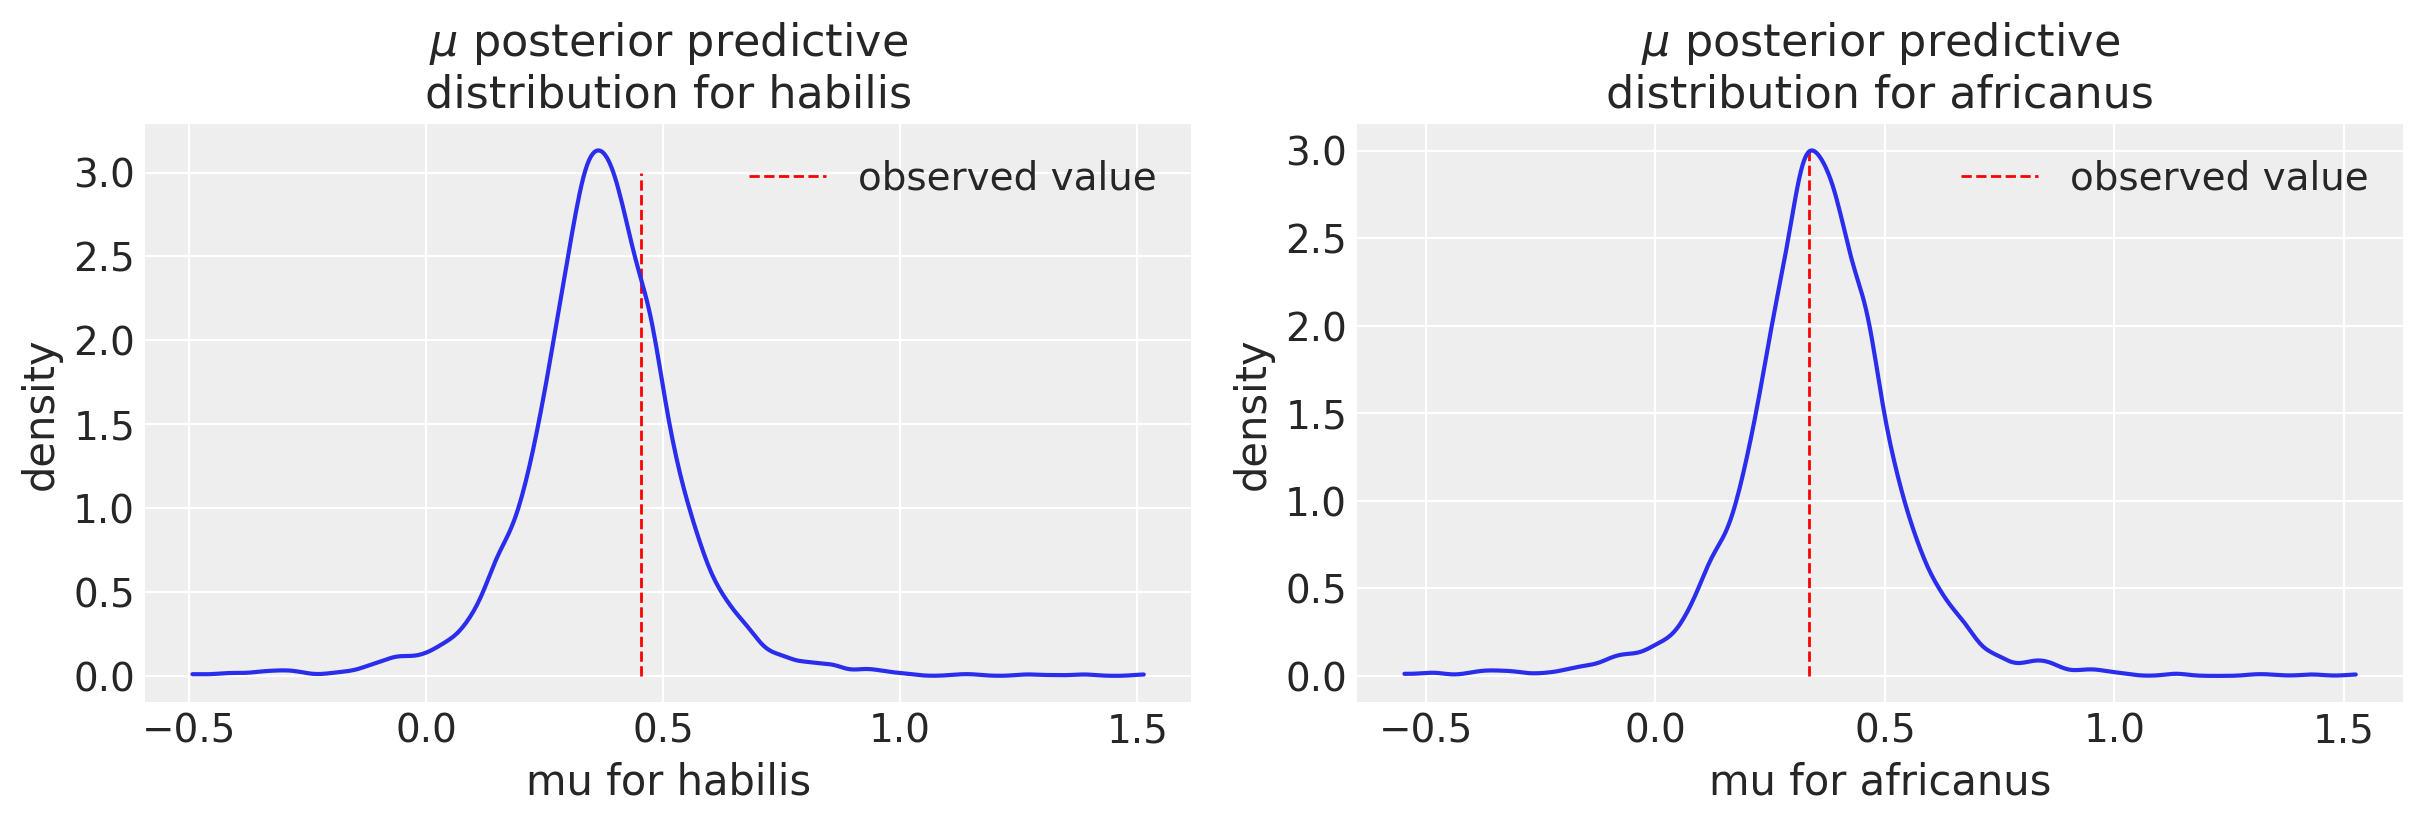

<IPython.core.display.Javascript object>

In [107]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

az.plot_kde(mu_for_africanus, ax=ax1)
ax1.set_title("$\mu$ posterior predictive\ndistribution for habilis")
ax1.set_ylabel("density")
ax1.set_xlabel("mu for habilis")
ax1.vlines(
    df_brains.loc[2, "brain_std"],
    ymin=0,
    ymax=3,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label="observed value",
)
ax1.legend()


az.plot_kde(mu_for_habilis, ax=ax2)
ax2.set_title("$\mu$ posterior predictive\ndistribution for africanus")
ax2.set_ylabel("density")
ax2.set_xlabel("mu for africanus")
ax2.vlines(
    df_brains.loc[1, "brain_std"],
    ymin=0,
    ymax=3,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label="observed value",
)
ax2.legend()

The posterior predictive distribution makes it clear that africanus is closer to its mean prediction with this model than habilis. We can see this in the scatter plot above as well but showing it this way brings us closer to how we can use it in the log score.

In [115]:
df_brains.head()

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.841920,0.324444
1,africanus,452,35.5,-0.990494,0.334815
2,habilis,612,34.5,-1.089544,0.453333
3,boisei,521,41.5,-0.396198,0.385926
4,rudolfensis,752,55.5,0.990494,0.557037


<IPython.core.display.Javascript object>

<ipython-input-124-2a31d772d2af>:39: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  f.tight_layout()


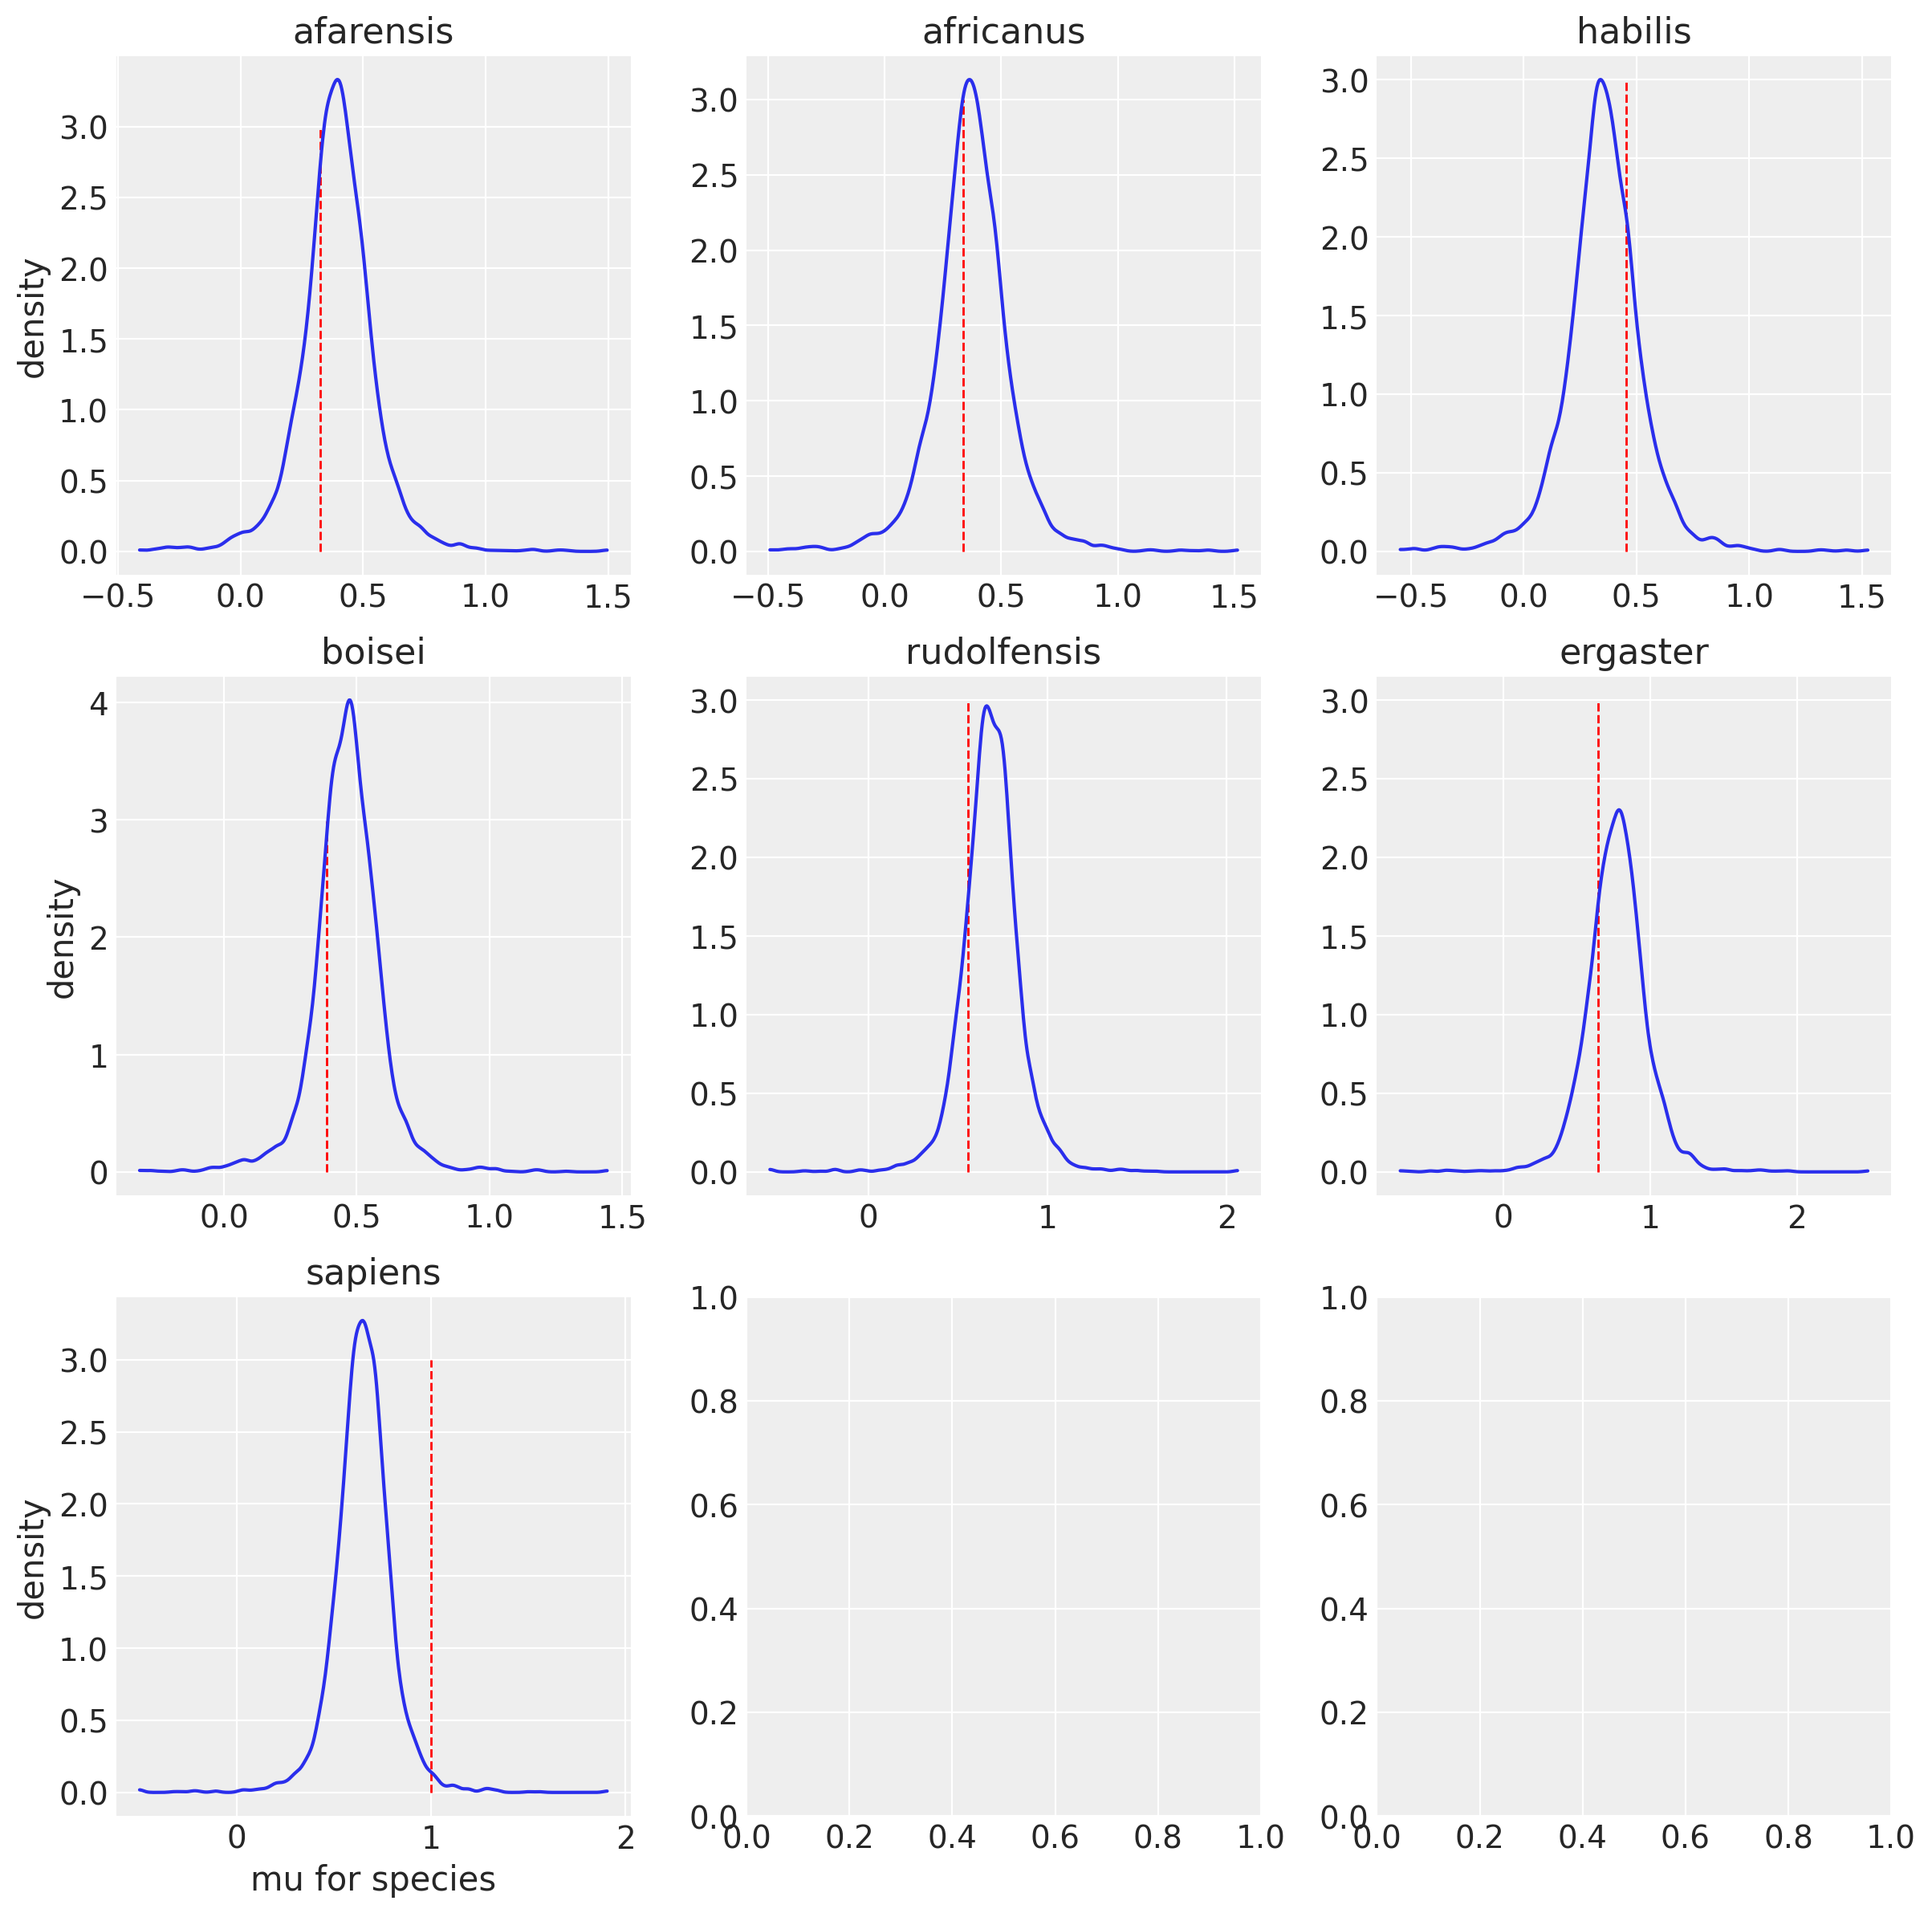

<IPython.core.display.Javascript object>

In [124]:
f, axes = plt.subplots(3, 3, figsize=(12, 12))


for i, species, ax in zip(df_brains.index, df_brains['species'], axes.flat):
    mu_for_species = (
    df_sample[("posterior", "a")]
    + df_sample[("posterior", "b")] * df_brains.loc[i, "mass_std"]
)
    
    az.plot_kde(mu_for_species, ax=ax)
    ax.set_title(species)
#     ax1.set_title("$\mu$ posterior predictive\ndistribution for habilis")
#     ax1.set_ylabel("density")
#     ax1.set_xlabel("mu for habilis")
    ax.vlines(
        df_brains.loc[i, "brain_std"],
        ymin=0,
        ymax=3,
        color="red",
        linestyle="dashed",
        linewidth=1,
        label='observed'
    )

    if ax.is_first_col():
        ax.set_ylabel("density")

    if ax.is_last_row():
        ax.set_xlabel("mu for species")

#     if ax.is_last_row():
#         ax.set_ylim(-500, 2100)
#         ax.axhline(0, ls="dashed", c="k", lw=1)
#         ax.set_yticks([0, 450, 1300])
#     else:
#         ax.set_ylim(300, 1600)
#         ax.set_yticks([450, 900, 1300])

f.tight_layout()

# az.plot_kde(mu_for_africanus, ax=ax1)
# ax1.set_title("$\mu$ posterior predictive\ndistribution for habilis")
# ax1.set_ylabel("density")
# ax1.set_xlabel("mu for habilis")
# ax1.vlines(
#     df_brains.loc[2, "brain_std"],
#     ymin=0,
#     ymax=3,
#     color="red",
#     linestyle="dashed",
#     linewidth=1,
#     label="observed value",
# )
# ax1.legend()


In [110]:
df_brains.loc[2, "brain_std"]

0.4533333333333333

<IPython.core.display.Javascript object>

In [114]:
((mu_for_habilis > 0.453) & (mu_for_habilis < 0.454)).sum()

8

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [12]:
%watermark -n -u -v -iv -w

Last updated: Thu Feb 18 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

numpy     : 1.20.1
matplotlib: 3.3.4
arviz     : 0.11.1
pandas    : 1.2.1
seaborn   : 0.11.1
json      : 2.0.9
pymc3     : 3.11.0
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>

In [13]:
# Custom scripts to show packages and versions in this notebook
def imports():
    import types

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__


imported_packages = list(imports())

from active_pkg import show_pkg_vers_in_nb

show_pkg_vers_in_nb(imported_packages)

# Name                    Version                   Build  Channel
arviz                     0.11.1                   pypi_0    pypi
matplotlib                3.3.4                    pypi_0    pypi
numpy                     1.20.1                   pypi_0    pypi
pandas                    1.2.1                    pypi_0    pypi
pymc3                     3.11.0                   pypi_0    pypi
scipy                     1.6.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi


<IPython.core.display.Javascript object>